Оценка показателей GaussianNB:
              precision    recall  f1-score   support

     Chansey       0.24      0.31      0.27        13
      Grimer       0.33      0.19      0.24        16
   Lickitung       0.64      0.58      0.61        12
         Muk       0.29      0.50      0.37        10
     Slowbro       0.31      0.45      0.37        11
    Slowpoke       0.29      0.13      0.18        15

    accuracy                           0.34        77
   macro avg       0.35      0.36      0.34        77
weighted avg       0.35      0.34      0.33        77

Оценка показателей Logistic_Regression:
              precision    recall  f1-score   support

     Chansey       0.78      0.54      0.64        13
      Grimer       0.58      0.44      0.50        16
   Lickitung       0.53      0.83      0.65        12
         Muk       0.45      0.50      0.48        10
     Slowbro       0.36      0.45      0.40        11
    Slowpoke       0.50      0.40      0.44        15

    ac

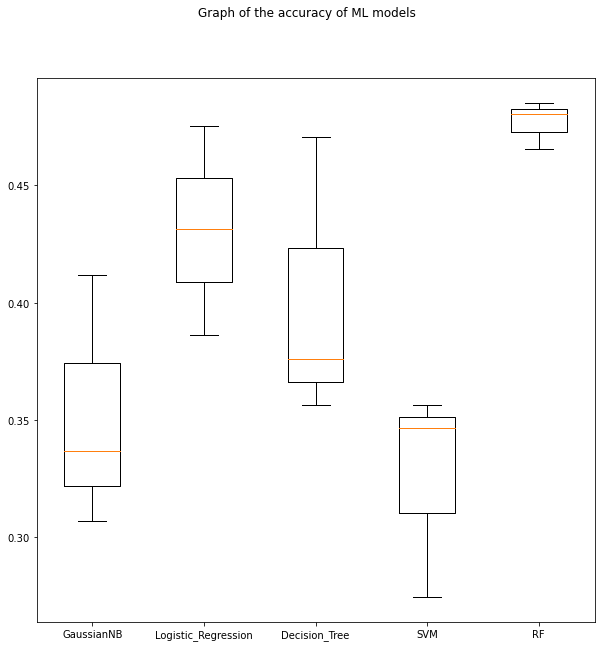

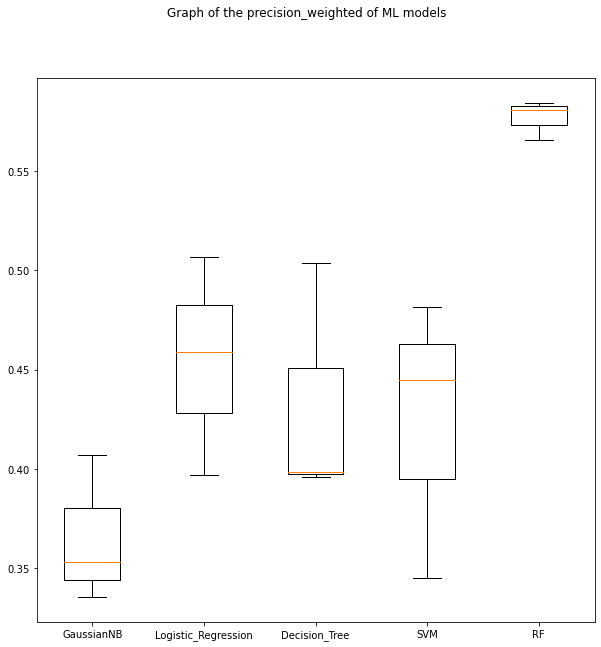

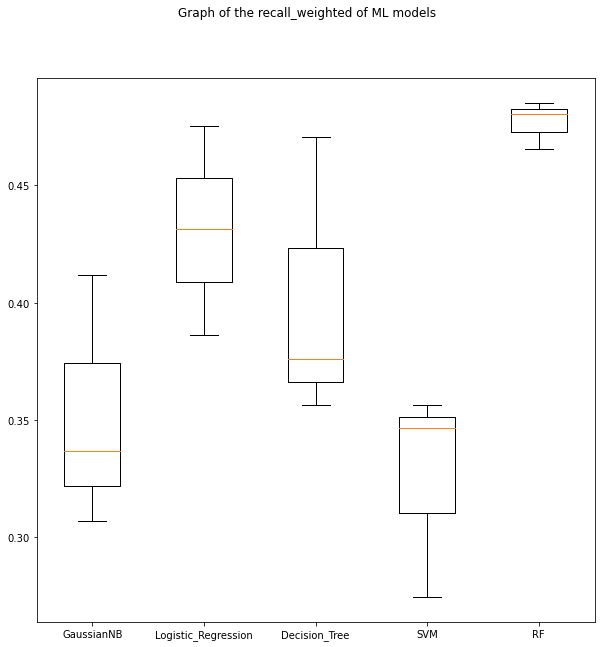

In [5]:
import h5py
import cv2
import numpy as np
import os
import import_ipynb
import features as fa
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from matplotlib import pyplot
from collections import namedtuple
from sklearn.metrics import classification_report


seed = 9
num_trees = 100
target_names = ['Chansey', 'Grimer', 'Lickitung', 'Muk', 'Slowbro', 'Slowpoke']

def init_models():
    Classifier = namedtuple('Classifier', 'name classifier')
    return (Classifier('GaussianNB', GaussianNB()),
            Classifier('Logistic_Regression', LogisticRegression(random_state=seed, max_iter=1000)),
            Classifier('Decision_Tree', DecisionTreeClassifier(random_state=seed)),
            Classifier('SVM', SVC(random_state=seed)),
            Classifier('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)),
            )

def normalization(features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(features)

def classifier(classifier_models, x_train_data, y_train_data):
    for elem in classifier_models:
        elem.classifier.fit(x_train_data, y_train_data)


def models_predict(classifier_models, x_test_data):
    predict_vector = []
    for elem in classifier_models:
        predict_vector.append((elem.name, elem.classifier.predict(x_test_data)))
    return predict_vector


def score_models(predict_list, y_test_data):
    for name, predict_vector in predict_list:
        print(f'Оценка показателей {name}:')
        print(classification_report(y_test_data, predict_vector, target_names=target_names))


def moustache_plot(models, x_train_data, y_train_data, metric):
    print(f'\nРасчет метрики {metric}:')
    results = []
    names = []
    for model_name, model in models:
        kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, x_train_data, y_train_data, cv=kfold, scoring=metric)
        results.append(cv_results)
        names.append(model_name)
        print(f'    {model_name}: {cv_results.mean()} ({cv_results.std()})')
        
    fig = pyplot.figure(figsize=(10,10))
    fig.suptitle(f'Graph of the {metric} of ML models')
    ax = fig.add_subplot()
    pyplot.boxplot(results)
    ax.set_xticklabels(names)
    pyplot.savefig(f'{metric}.png')


def test_models(classifier):
    test_dir = os.path.join(os.getcwd(), 'test')
    for image_path in os.listdir(test_dir):
        if image_path.endswith(".png") or image_path.endswith(".jpg"):
            global_image_path = os.path.join(test_dir, image_path)
            img_features = fa.extract_features(global_image_path)
            pokemon_predict = classifier.classifier.predict([img_features])
            add_pokemon_name(global_image_path, pokemon_predict)


def add_pokemon_name(image_path, pokemon_index):
    filename = image_path.split('/')[-1]
    img = cv2.imread(image_path)
    cv2.putText(img, target_names[pokemon_index[0]], (20, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    cv2.imwrite(f'{filename.split(".")[0]}_detected.jpg', img)


if __name__ == '__main__':
    models = init_models()
    global_features = []
    global_labels = []
    
    with h5py.File('feature_values', 'r') as h5f_data:
        global_features_string = h5f_data['dataset_1']
        global_features = np.array(global_features_string)
    with h5py.File('pokemon_names', 'r') as h5f_label:
        global_labels_string = h5f_label['dataset_1']
        global_labels = np.array(global_labels_string)
        
    x_train, x_test, y_train, y_test = train_test_split(global_features, global_labels, test_size=0.2, random_state=seed)
    classifier_scoring(models, x_train, y_train)
    prediction_list = models_predict(models, x_test)
    score_models(prediction_list, y_test)
    
    for metric in ('accuracy', 'precision_weighted', 'recall_weighted'):
        moustache_plot(models, x_train, y_train, metric)
    
    test_models(models[4])
